# Implementing DistilBERT

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import torch as tc
import transformers as tns
import tensorflow as tf
import textblob as tb
import regex as re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression

_wordnet = nltk.corpus.wordnet

## Read Data

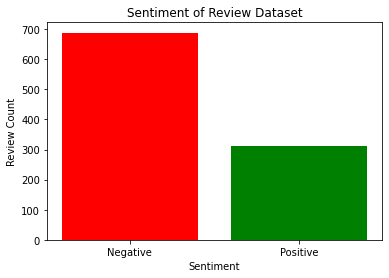

In [2]:
# Uncomment for sample of 100 reviews
# sourcefile = 'Data/review_100.json'

# Uncomment for sample of 1,000 reviews
sourcefile = 'Data/review_1000.json'

# Uncomment for sample of 10,000 reviews
# sourcefile = 'Data/review_10000.json'

# Load into DataFrame
data = pd.read_json(sourcefile, lines=True)

# Add Sentiment Column and Restructure DataFrame
data['Sentiment'] = data['stars'].apply(lambda score: "Positive" if score > 3 else "Negative")
data.rename(columns={'text':'Review', 'stars':'Rating'}, inplace=True)
data = data[['Review', 'Rating', 'Sentiment']]

# Display the sentiment distribution
plt.bar(data.Sentiment.unique(), data.Sentiment.value_counts(), color = ['red', 'green'])
plt.title('Sentiment of Review Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Review Count')

# Convert 'Positive' or 'Negative' to 1 or 0
data['Sentiment'] = data['Sentiment'].apply(lambda score: 1 if score == 'Positive' else 0)

In [3]:
data.sample(10)

,Review,Rating,Sentiment
379,I had the worst experience of my life and it's...,1,0
112,Westfall replaced our roof in April. We could ...,5,1
540,Drum-roll please! Review #100 coming right up!...,4,1
374,What a disappointment. This place was not good...,1,0
386,I stopped in because I was hungry for some sna...,4,1
260,"You think Value City, you think cheap value, r...",1,0
174,This small little donut bakery is located in o...,5,1
559,We love this movie theater/ bar/ restaurant. G...,4,1
656,We had a mixed experience at Mr. B's. We star...,3,0
225,Love the sweet spiral plain pies at Franzones....,4,1


## Preprocessing

In [4]:
def preprocess(review):
    cleaned = []
    review = re.sub(r'&amp;', '&', review)
    review = re.sub(r'\s+', ' ', review).strip()
    for word in review.split():
        cleaned.append(lemmatize(word))
    return ' '.join(cleaned)

def lemmatize(word):
    word = tb.Word(word).lemmatize()
    word = tb.Word(word).lemmatize(_wordnet.VERB)
    word = tb.Word(word).lemmatize(_wordnet.ADJ)
    word = tb.Word(word).lemmatize(_wordnet.ADV)
    return word

In [5]:
data['Review'] = data.apply(lambda row: preprocess(row['Review']), axis=1)

## Model Creation and Tuning

In [6]:
tokenizer = tns.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = tns.DistilBertModel.from_pretrained('distilbert-base-uncased', dropout=0.2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
# Encode the reviews into token embeddings
tokenized = data['Review'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, padding='max_length', truncation=True, max_length=512))

In [8]:
# Display sample of the tokenized values
tokenized

0      [101, 2065, 2017, 5630, 2000, 4521, 2182, 1010...
1      [101, 1045, 1005, 2310, 2202, 1037, 2843, 1997...
2      [101, 2155, 15736, 1012, 2018, 1996, 28305, 10...
3      [101, 10166, 999, 9805, 18879, 1010, 2367, 101...
4      [101, 10140, 4592, 1998, 3954, 1006, 1029, 100...
                             ...                        
995    [101, 1045, 3728, 10885, 1999, 2358, 1012, 806...
996    [101, 2200, 4658, 3347, 22476, 2000, 1996, 365...
997    [101, 2023, 3309, 2022, 1037, 17070, 1999, 199...
998    [101, 2001, 2202, 2182, 2651, 2011, 1037, 1359...
999    [101, 2026, 2767, 1998, 1045, 2035, 2131, 2028...
Name: Review, Length: 1000, dtype: object

In [9]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

print(max_len)

512


In [10]:
np.array(padded).shape

(1000, 512)

In [11]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(1000, 512)

## Model Training

In [12]:
# Model training may take a long time

input_ids = tc.tensor(tokenized)
attention_mask = tc.tensor(attention_mask)

with tc.no_grad():
    model_output = model(input_ids, attention_mask=attention_mask)

## Model Performance Test

In [13]:
# Obtain test sets and labels

features = model_output[0][:,0,:].numpy()
labels = data['Sentiment']

train_features, test_features, train_labels, test_labels = tts(features, labels)

In [14]:
lr_clf = LogisticRegression(max_iter=250)
lr_clf.fit(train_features, train_labels)

C:\Users\cdbul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## Model Accuracy Check

In [15]:
lr_clf.score(test_features, test_labels)

0.88

In [16]:
model.save_pretrained('./sentiment')